In [1]:
import numpy as np
import math
import prune
import os
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm

#create ./image_output/ folder if your want to store iamges!

# os.environ["OMP_NUM_THREADS"] = "1" #remove if run of GPU
mp = prune.ModelPruner('resnet18', 'MNIST', 'by_parameter')
print(mp.baseline)

c:\Users\potadoo\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load model: ./model_weights/resnet18_MNIST.pt...
{'loss': 0.02684426321648061, 'acc': 99.375}


In [2]:
!cd ./Network-Pruning-with-EC

�t�Χ䤣����w�����|�C


In [3]:
# the phony generator
def generator(in_arr):
    pruned_model = mp.prune_model(in_arr)
    return mp.get_fitness_score(pruned_model)

def N_step_single_pass(decision_len, deci_arr_in, stepsize_arr_in, tau_prum_in, tau_in, elpslon_zero):
    random_normal_i = np.random.normal(0, 1, size=(decision_len))
    random_normal = np.random.normal(0, 1, size=(1))
    
    #store input variable
    deci_arr = np.copy(deci_arr_in)
    stepsize_arr = np.copy(stepsize_arr_in)
    
    for i in range(decision_len):
        stepsize_arr[i]*=math.exp(tau_prum_in*random_normal[0]+tau_in*random_normal_i[i])

        if(stepsize_arr[i] > elpslon_zero):
            deci_arr[i] += stepsize_arr[i]*random_normal_i[i]
        else:
            deci_arr[i] += elpslon_zero*random_normal_i[i]

        if(deci_arr[i] <= 0.001):
            deci_arr[i] = 0.001
        elif(deci_arr[i] >= 0.999):
            deci_arr[i] = 0.999

    return deci_arr, stepsize_arr


def ESXPlusX_NS(Decision_var_record, Stepsize_record, Best_score_record,
                Decision_arr_init, Stepsize_arr_init, Best_acc_record,
                Target_run, child_lambda, hp_tau_prum, hp_tau, hp_elpslon_zero):
    train_runs = 0
    
    decision_var_arr = np.copy(Decision_arr_init)
    stepsize_arr = np.copy(Stepsize_arr_init)
    best_score, best_acc = generator(decision_var_arr)
    
    tau_in = hp_tau/((1/math.sqrt(2*len(Decision_arr_init))))
    tau_prum_in = hp_tau_prum/math.sqrt(2*math.sqrt(len(Decision_arr_init)))

    while(train_runs < Target_run):
        print(f'Training epoch: {train_runs+1}/{Target_run}')
        memorize_parent_decision_var_arr = np.copy(decision_var_arr)
        memorize_parent_stepsize_arr = np.copy(stepsize_arr)
 
        for run in range(child_lambda):
            tmp_decision_var_arr, tmp_stepsize = N_step_single_pass(len(Decision_arr_init),memorize_parent_decision_var_arr,memorize_parent_stepsize_arr,
                                                                    tau_prum_in, tau_in, hp_elpslon_zero)
            tmp_score, tmp_acc = generator(tmp_decision_var_arr)


            if(tmp_score < best_score):
                best_score = tmp_score
                best_acc = tmp_acc
                decision_var_arr = np.copy(tmp_decision_var_arr)
                stepsize_arr = tmp_stepsize
        Decision_var_record.append(decision_var_arr)
        Stepsize_record.append(stepsize_arr)
        Best_score_record.append(best_score)
        Best_acc_record.append(best_acc)
        train_runs+=1

    return decision_var_arr, stepsize_arr, best_score




In [4]:
#Hyperparameters could be change here:

HP_DECISION_INITVAL = 0.5   # Initial value for decision variable (array)
HP_STEPSIZE_INITVAL = 0.1   # Initial value for stepsize (array)
HP_ITERATIONS = 10          # Run how many iterations/epoch
HP_CHILD_LAMBDA = 2         # Run (1+child_lambda)-EC
HP_TAU_PRUM_PARAM = 0.05    # global step size changing parameter, tau_prum = HP_TAU_PRUM_PARAM/sqrt(2*sqrt(N))
HP_TAU_PARAM = 0.05         # local step size changing parameter, tau = HP_TAU_PARAM/sqrt(2*N)
HP_ELPSLON_VALUE = 0.001    # The threshold of the step size, if stepsize < elpslon, stepsize=elpslon


#auto generated parameter (Don't change)
Decision_arr = np.array([HP_DECISION_INITVAL for i in range(mp.prunable_layer_num)]) 
Stepsize_arr = np.array([HP_STEPSIZE_INITVAL for i in range(mp.prunable_layer_num)]) 


DV_record = [] #records the decision variable of each epoch
SZ_record = [] #records the step size of each epoch
BS_reocrd = [] #records the best solution of each run
BA_record = [] #records the acc of best solution of each run

#run EC algorithm
ans_decvar, ans_stepsize, ans_bestscore = ESXPlusX_NS(Decision_var_record=DV_record,Stepsize_record=SZ_record,Best_score_record=BS_reocrd, 
            Decision_arr_init=Decision_arr,Stepsize_arr_init=Stepsize_arr, Best_acc_record=BA_record,
            Target_run=HP_ITERATIONS,child_lambda=HP_CHILD_LAMBDA,
            hp_tau_prum=HP_TAU_PRUM_PARAM, hp_tau=HP_TAU_PARAM, hp_elpslon_zero=HP_ELPSLON_VALUE)


print(DV_record)
print(SZ_record)
print(BS_reocrd)
print(BA_record)



Training epoch: 1/10
Training epoch: 2/10
Training epoch: 3/10
Training epoch: 4/10
Training epoch: 5/10
Training epoch: 6/10
Training epoch: 7/10
Training epoch: 8/10
Training epoch: 9/10
Training epoch: 10/10
[array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]), array([0.75801142, 0.46196021, 0.49795727, 0.45623035, 0.42168045,
       0.61533673, 0.4035291 , 0.47317098, 0.50097268, 0.59028983,
       0.52071463, 0.45023438, 0.43539885, 0.49400198, 0.55899186,
       0.46487682, 0.48768612, 0.47619373, 0.70332366, 0.5818295 ]), array([0.75801142, 0.46196021, 0.49795727, 0.45623035, 0.42168045,
       0.61533673, 0.4035291 , 0.47317098, 0.50097268, 0.59028983,
       0.52071463, 0.45023438, 0.43539885, 0.49400198, 0.55899186,
       0.46487682, 0.48768612, 0.47619373, 0.70332366, 0.5818295 ]), array([0.75801142, 0.46196021, 0.49795727, 0.45623035, 0.42168045,
       0.61533673, 0.4035291 , 0.47317098, 0.50097268, 0.59028983

OSError: [Errno 22] Invalid argument: './image_output/VGG11NStepEC_10runs_2022-12-15 22:52:50.png'

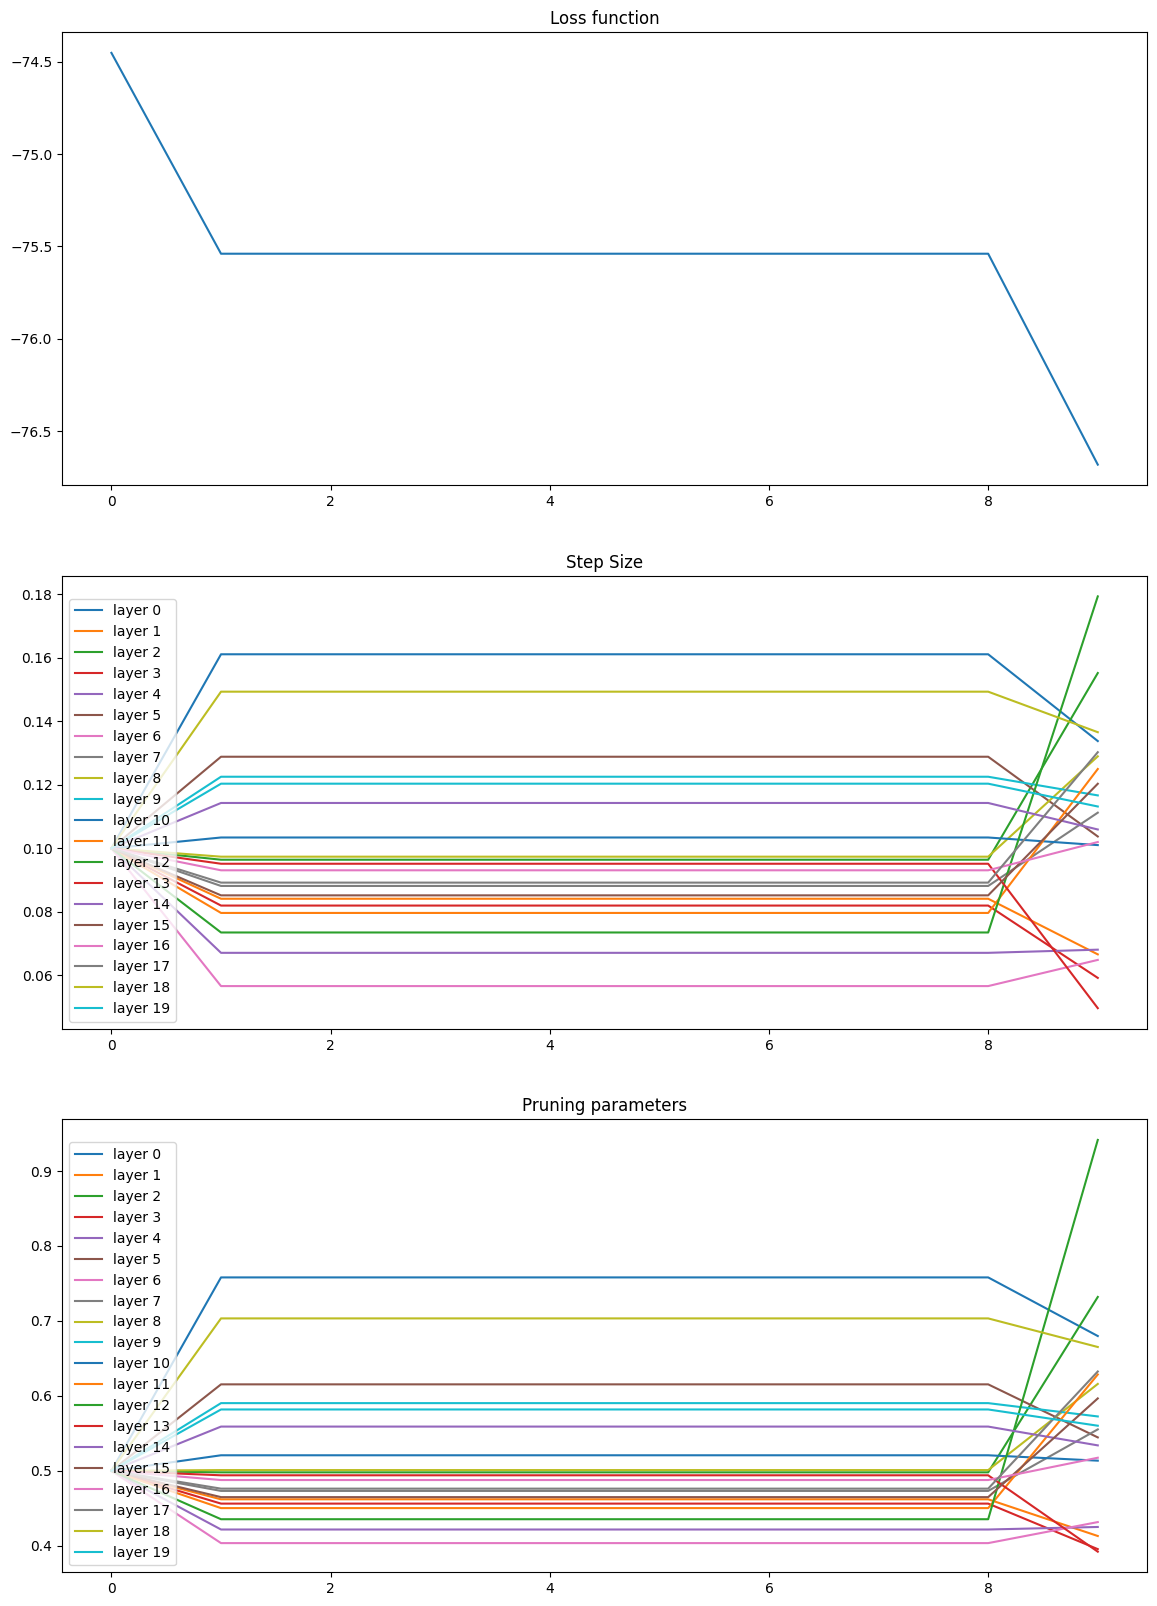

In [5]:
#visualize the result
def plotOSResult(arr1, arr2d_1, arr2d, model_name):
    run_num = len(arr1)
    parm_num = len(arr2d[0])
    plt.figure(figsize=(14,20))
    
    ax1 = plt.subplot(311)
    ax1.plot(arr1)
    ax1.set_title('Loss function')

    ax2 = plt.subplot(312)
    for line in range(parm_num):
        ax2.plot([arr2d_1[j][line] for j in range(run_num)], label = f'layer {line}')
    ax2.set_title('Step Size')
    ax2.legend(loc=3)

    ax3 = plt.subplot(313)
    for line in range(parm_num):
        ax3.plot([arr2d[j][line] for j in range(run_num)], label = f'layer {line}')

    ax3.set_title('Pruning parameters')    
    ax3.legend(loc=3)   

    now=datetime.now()
    time_print=now.strftime("%Y-%m-%d %H:%M:%S")
    #change the saving directory if your want to
    plt.savefig(f'./image_output/{model_name}NStepEC_{run_num}runs_{time_print}.png',dpi = 400)
    plt.show()
    

plotOSResult(BS_reocrd,SZ_record,DV_record,"VGG11")

